# Train ConvNext on Diabetic Retinopathy IDRiD dataset

In [39]:
from pathlib import Path
import random
import sys

import pandas as pd
import torch
from PIL import Image

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [2]:
!export KAGGLE_API_TOKEN=""

## Setup

In [3]:
%cd /content/
! rm -rf retinal-disease-classification
!git clone https://github.com/Tejashree-Khot/retinal-disease-classification.git

/content
Cloning into 'retinal-disease-classification'...
remote: Enumerating objects: 250, done.
remote: Counting objects: 100% (250/250), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 250 (delta 166), reused 170 (delta 89), pack-reused 0 (from 0)
Receiving objects: 100% (250/250), 8.11 MiB | 15.01 MiB/s, done.
Resolving deltas: 100% (166/166), done.


In [71]:
%cd /content/retinal-disease-classification
! git pull
! uv sync --quiet
%cd /content/retinal-disease-classification/src
sys.path.append("/content/retinal-disease-classification/src")

/content/retinal-disease-classification
Already up to date.
/content/retinal-disease-classification/src


## Dataset **Preparation**

In [5]:
! uv run python3 ../scripts/download_dataset.py

Path to dataset files: /content/retinal-disease-classification/src/../data


In [6]:
! pwd
! ls ../data/

/content/retinal-disease-classification/src
IDRiD


In [7]:
train_df = pd.read_csv(Path("../data/IDRiD/Train/annotations.csv"))
test_df = pd.read_csv(Path("../data/IDRiD/Test/annotations.csv"))
train_df.head()

Image name  Retinopathy grade  Risk of macular edema  \
0  IDRiD_0001.jpg                  0                      0   
1  IDRiD_0002.jpg                  1                      0   
2  IDRiD_0003.jpg                  2                      2   
3  IDRiD_0004.jpg                  0                      0   
4  IDRiD_0005.jpg                  3                      2   

                                  class  \
0                                 No_DR   
1                    Mild_Moderate_NPDR   
2  Clinically_Significant_Macular_Edema   
3                                 No_DR   
4  Clinically_Significant_Macular_Edema   

                                             caption  
0  A fundus photograph of a healthy retina, class...  
1  A fundus image of a patient with Mild_Moderate...  
2  This fundus photograph illustrates Clinically_...  
3  A fundus photograph of a healthy retina, class...  
4  This fundus photograph illustrates Clinically_...

## Training

In [20]:
%cd /content/retinal-disease-classification/src
!python3 train.py

/content/retinal-disease-classification/src
wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from /root/.netrc.
wandb: Currently logged in as: tejashreekhot (tejashreekhot-ai) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: ⢿ Waiting for wandb.init()...
wandb: ⣻ Waiting for wandb.init()...
wandb: ⣽ Waiting for wandb.init()...
wandb: Tracking run with wandb version 0.24.0
wandb: Run data is saved locally in /content/retinal-disease-classification/output/wandb/run-20260125_103446-lwymgfa6
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run convnext_large_edema_epochs_2
wandb: ⭐️ View project at https://wandb.ai/tejashreekhot-ai/retinal-classification
wandb: 🚀 View run at https://wandb.ai/tejashreekhot-ai/retinal-classification/runs/lwymgfa6
INFO:   Model: convnext, Parameters: 196,234,947
INFO:   Loading 1239 image_paths from /content/retinal-disease-classification/data/IDRiD/Train...
INFO:   Loaded 1239 image_paths from /cont

In [21]:
!python3 test.py --model_name convnext --variant large

INFO:   Model loaded for inference from /content/retinal-disease-classification/output/checkpoints/convnext_large_best_model.pt
INFO:   Loaded model from /content/retinal-disease-classification/output/checkpoints/convnext_large_best_model.pt
INFO:   Loading 309 image_paths from /content/retinal-disease-classification/data/IDRiD/Test...
INFO:   Loaded 309 image_paths from /content/retinal-disease-classification/data/IDRiD/Test.
INFO:   Test samples: 309
Evaluating: 100% 39/39 [00:21<00:00,  1.80it/s, loss=0.5775, f1=0.7107]
INFO:   ------------------------------------------------------------------------------
INFO:   Split    | Loss     Acc    F1     Prec   Recall  QWK   
INFO:   ------------------------------------------------------------------------------
INFO:   Test     | 0.6543   0.7832 0.7107 0.7180 0.7685  0.8063
INFO:   ------------------------------------------------------------------------------


In [22]:
!python3 inference.py --model_name convnext --variant large --image_path ../data/IDRiD/Test/images/IDRiD_0001.jpg

INFO:   Model loaded for inference from /content/retinal-disease-classification/output/checkpoints/convnext_large_best_model.pt
INFO:   Loaded model from /content/retinal-disease-classification/output/checkpoints/convnext_large_best_model.pt
INFO:   
Predictions for 1 images:
INFO:     IDRiD_0001.jpg: 0 (index: 0, confidence: 0.5955)


## Prediction Analysis

In [ ]:
from dataloader.data_utils import CLASSES_DICT, CLASSES


def plot_classwise_predictions(pred_csv_path: Path, image_dir: Path, pred_col="predictions"):
    df = pd.read_csv(pred_csv_path)
    image_paths = sorted(list(image_dir.glob("*.jpg")))

    n = len(CLASSES)
    fig, ax = plt.subplots(2, n, figsize=(4*n, 8))
    random.seed(42)

    splits = [
        df[df.labels == df[pred_col]],   # correct
        df[df.labels != df[pred_col]],   # wrong
    ]

    for i, cls in enumerate(CLASSES):
        cls_id = CLASSES_DICT[cls]

        for r, sub_df in enumerate(splits):
            row = sub_df[sub_df.labels == cls_id].sample(1).iloc[0]
            img = mpimg.imread(image_paths[row.name])

            ax[r, i].imshow(img)
            ax[r, i].set_title(
                f"GT: {CLASSES[row.labels]} | Pred: {CLASSES[row[pred_col]]}",
                fontsize=9
            )
            ax[r, i].axis("off")

    ax[0, 0].set_ylabel("Correct")
    ax[1, 0].set_ylabel("Wrong")
    plt.tight_layout()
    plt.show()


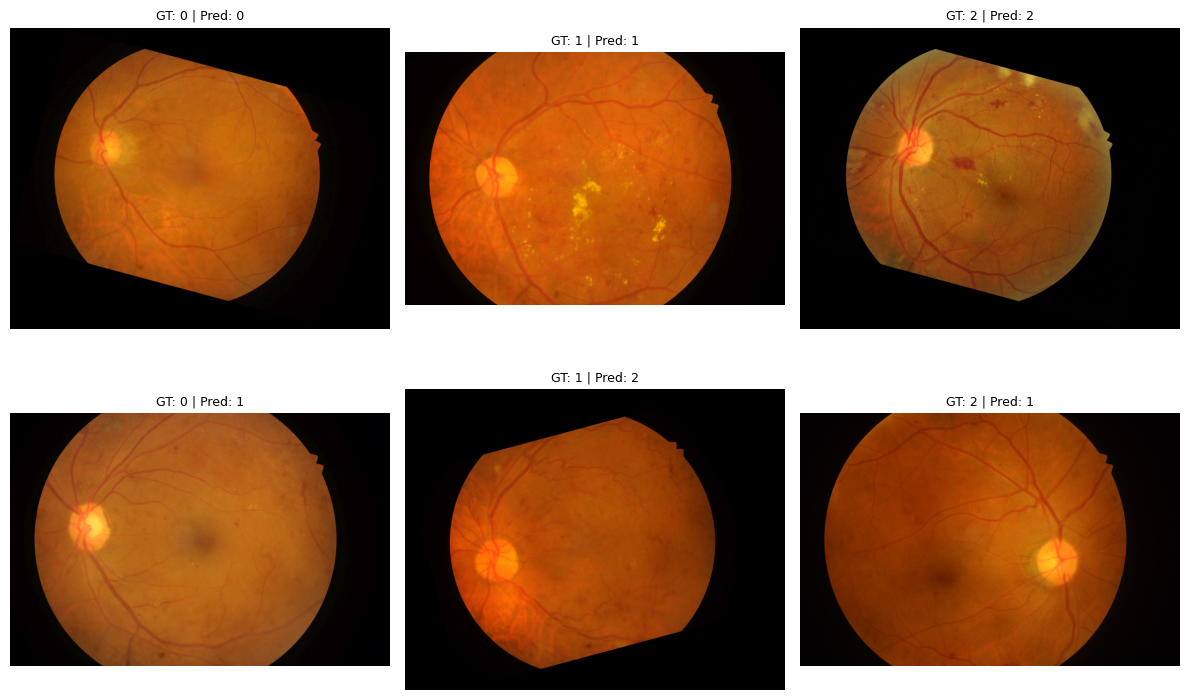

In [28]:
plot_classwise_predictions(Path("test_predictions.csv"), Path("../data/IDRiD/Test/images"))

## Model Analysis

In [65]:
!python3 ../scripts/visualize_feature_maps.py --model_name convnext --variant large --image_path ../data/IDRiD/Test/images/IDRiD_0001.jpg


INFO:   Visualizing feature maps for IDRiD_0001.jpg
INFO:   Model loaded for inference from /content/retinal-disease-classification/src/../output/checkpoints/convnext_large_best_model.pt
INFO:   Loaded model for visualization from /content/retinal-disease-classification/src/../output/checkpoints/convnext_large_best_model.pt
INFO:   Animating layer evolution for convnext_large
INFO:   Animation.save using <class 'matplotlib.animation.PillowWriter'>


In [67]:
def display_original_image(model_name: str, variant: str):
    plot_dir = Path("../output/feature_maps")
    original_image_path = plot_dir / f"{model_name}_{variant}_input_image.jpg"
    print(original_image_path)
    img = mpimg.imread(original_image_path)
    plt.imshow(img)
    plt.show()

def display_all_feature_maps(model_name: str, variant: str):
    plot_dir = Path("../output/feature_maps")
    image_paths = sorted(list(plot_dir.rglob(f"{model_name}_{variant}_*.png")))
    for image_path in image_paths:
        print("Layer", image_path.stem.split("_")[-1])
        display(Image.open(image_path))

../output/feature_maps/convnext_large_input_image.jpg


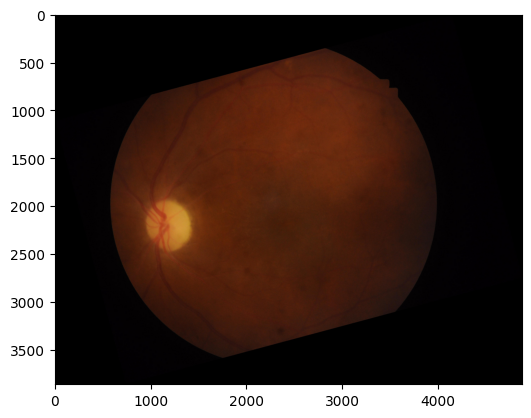

Layer 0


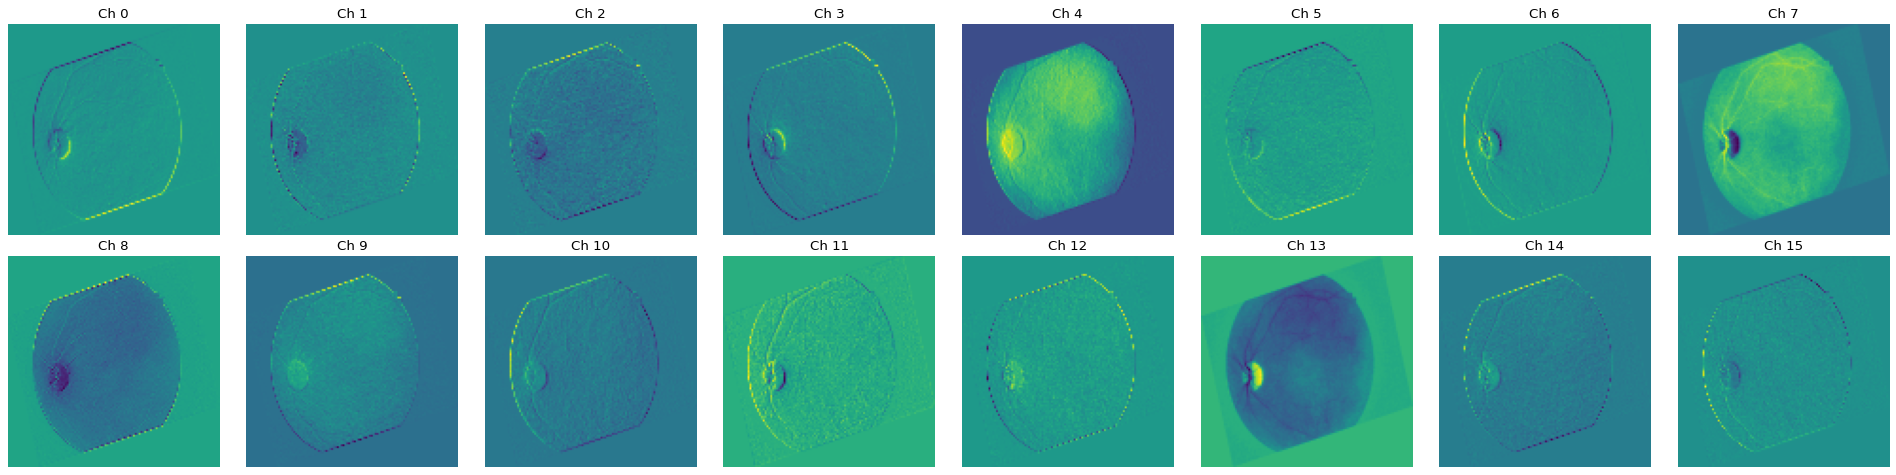

Layer 1


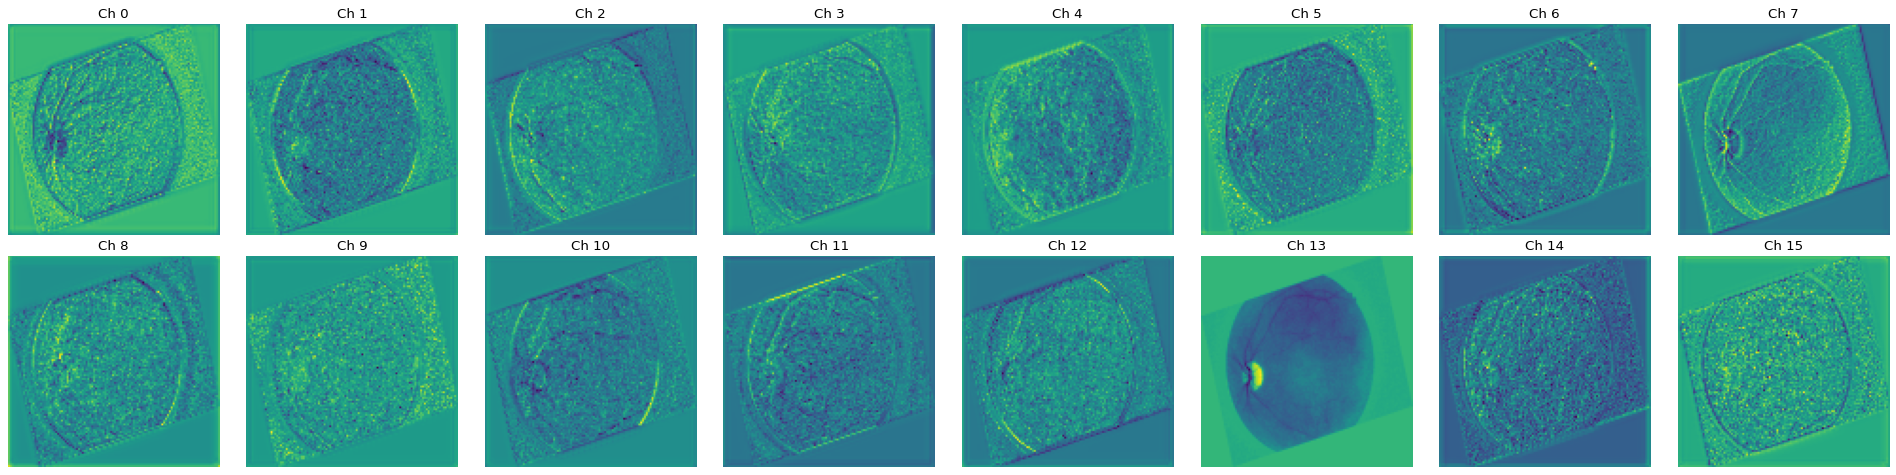

Layer 2


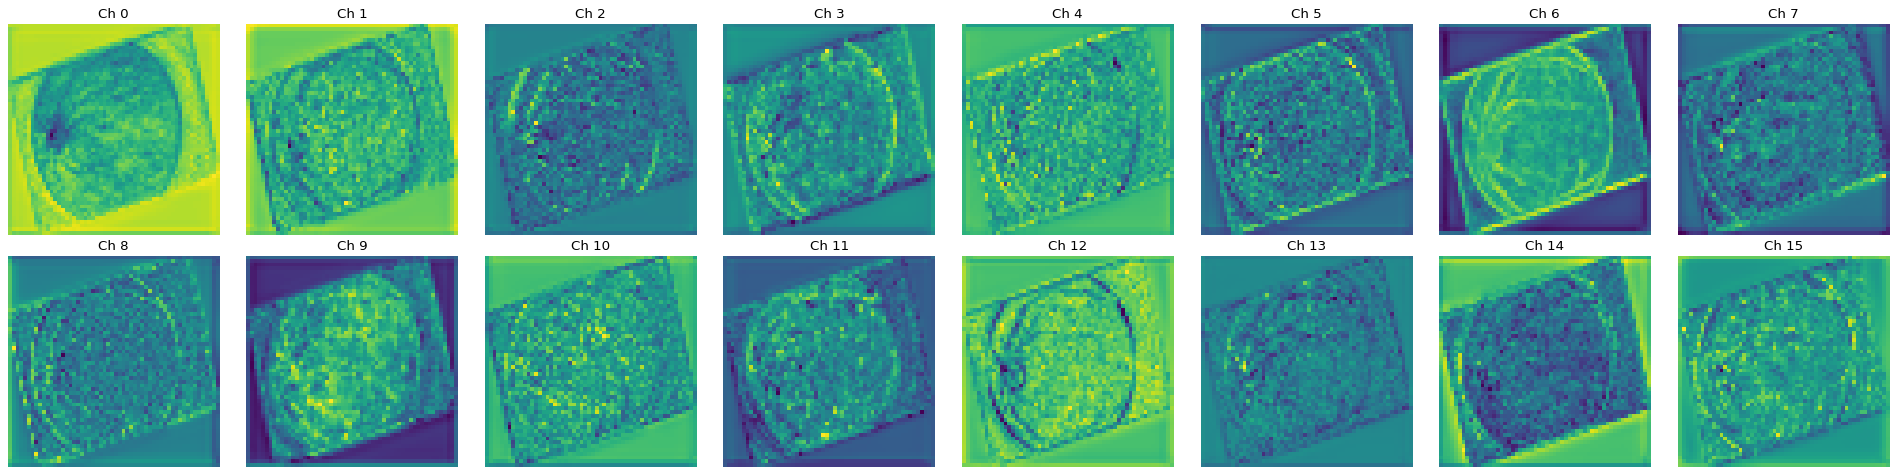

Layer 3


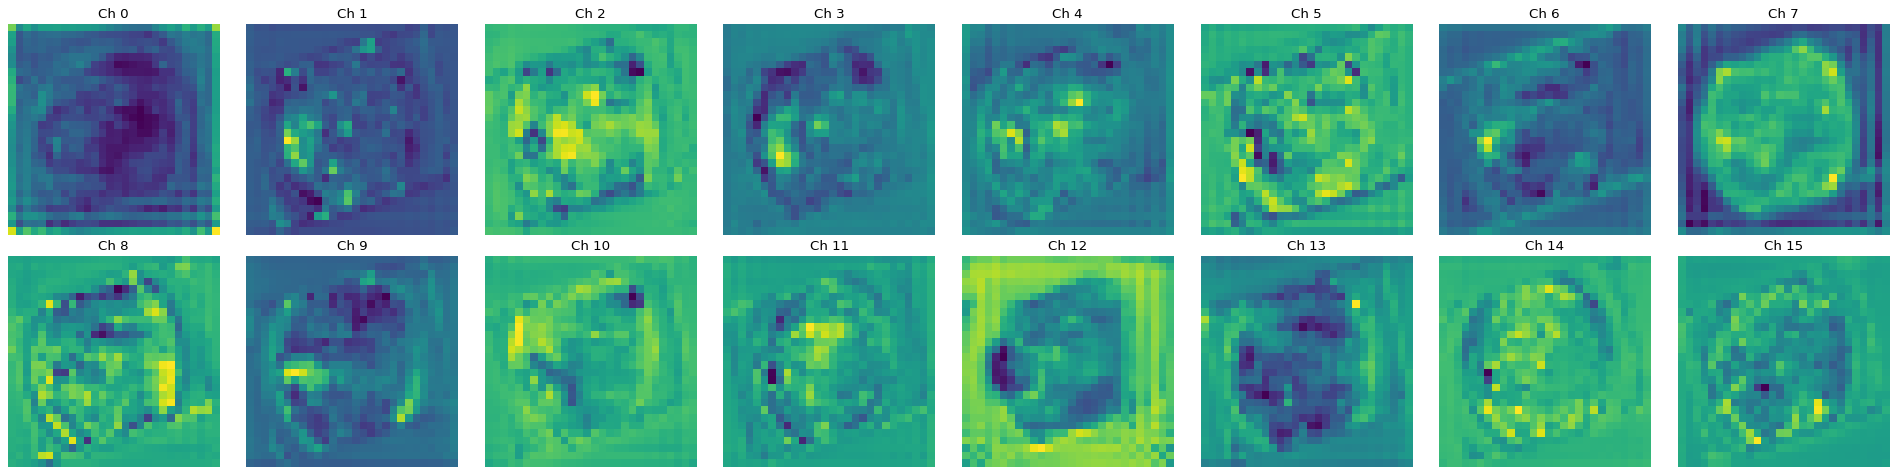

Layer 4


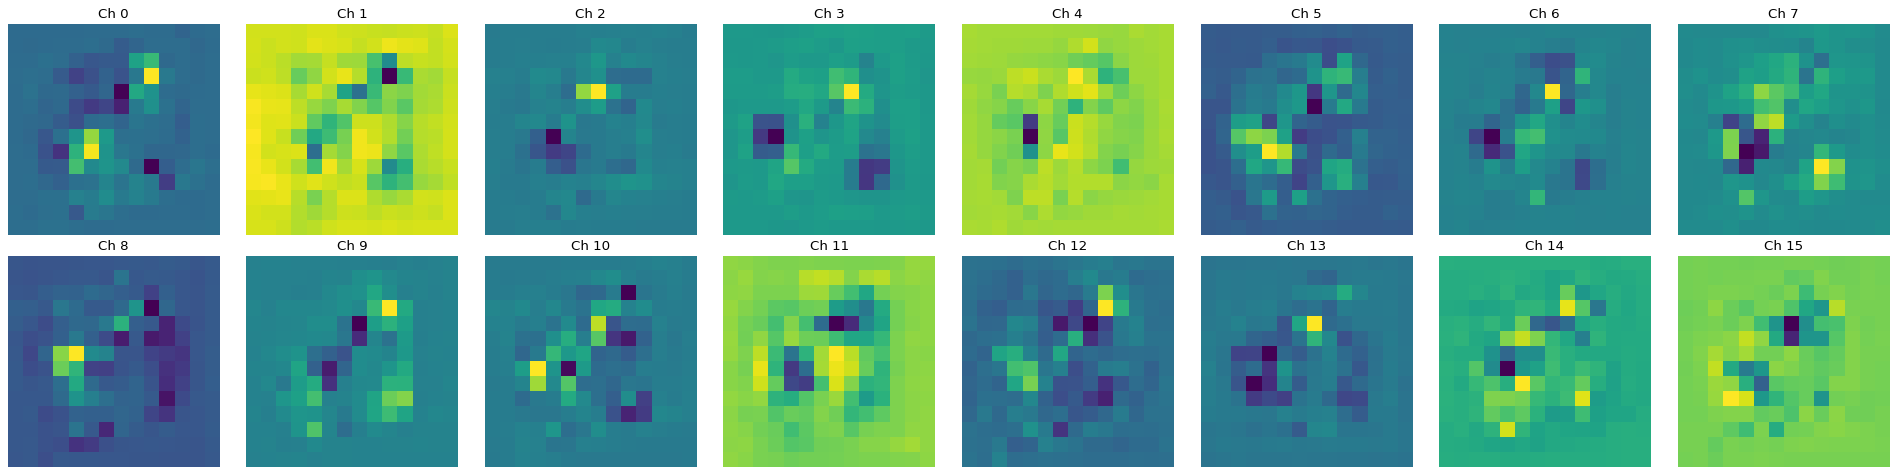

In [51]:
display_original_image("convnext", "large")
display_all_feature_maps("convnext", "large")

In [81]:
! python3 ../scripts/visualize_gradcam.py --prediction_csv test_predictions.csv

INFO:   Model loaded for inference from /content/retinal-disease-classification/src/../output/checkpoints/convnext_large_best_model.pt
INFO:   Loaded model for visualization from /content/retinal-disease-classification/src/../output/checkpoints/convnext_large_best_model.pt
INFO:   Plotting classwise Grad-CAM for test_predictions.csv


gradcam


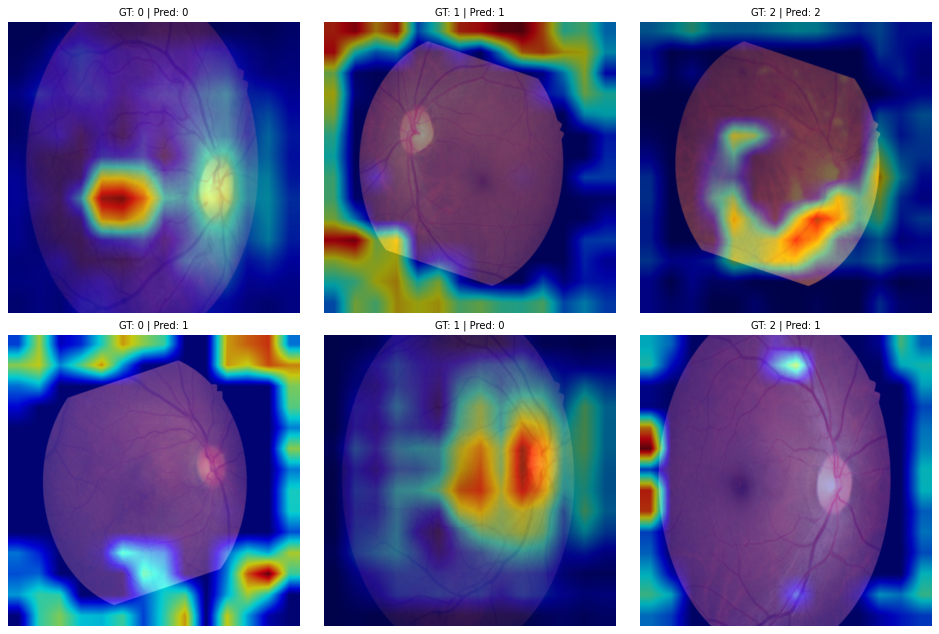

In [82]:
def display_all_gradcam(model_name: str, variant: str):
    plot_dir = Path("../output/gradcam")
    image_paths = sorted(list(plot_dir.rglob(f"{model_name}_{variant}_*.png")))
    for image_path in image_paths:
        print(image_path.stem.split("_")[-1])
        display(Image.open(image_path))

display_all_gradcam("convnext", "large")